This notebook creates a conversion table for census tracts mapping from 2019 to 2020. It also prints accuracy matrics for the interpolation

In [1]:
# import libraries

import pandas as pd
import geopandas
import numpy as np
import seaborn as sns
import folium
from scipy import stats
from io import BytesIO
import requests

In [2]:
# Skip geometry column due to type mismatch

# Read grund truth values for 2020 census tracts
tract_truths = pd.read_csv("tracts2020.csv")
tract_truths = tract_truths.drop(columns="geometry")

# Read grund interpolated values for census tracts
tract_interpolated = pd.read_csv("interpolated.csv")
tract_interpolated = tract_interpolated.drop(columns="geometry") # Use population as weights
#tract_interpolated = pd.read_csv("interpolated_house.csv")
#tract_interpolated = tract_interpolated.drop(columns="geometry")# Use houses as weights

Create conversion table

In [3]:
# For each 2020 census tract, stores all associated 2019 census tracts in a list
conversion_table = []

# Get all the column names corresponding to tracts
tract2019_cols = [col for col in tract_interpolated.columns.tolist()[1:] if 'GEOID' in col]

# Iterate over 2019 tracts
for tract in tract2019_cols:
    # Create a dataframe for related tracts
    related = tract_interpolated.loc[tract_interpolated[tract] > 0][["GEOID", tract]]
    # List for 2020 tracts related to the 2019 tract
    table = [tract[6:], []]
    # For each tract relating to the 2019 tract
    for index, tract2020 in related.iterrows():
        table[1].append((tract2020["GEOID"].astype(int), tract2020[tract]))
    conversion_table.append(table)

In [4]:
# Write conversion table to a csv
conversion_frame = pd.DataFrame(data=conversion_table, columns = ["Tract_2019", "Tract_2020"])
conversion_frame.to_csv("conversion_table.csv", index=False)

Transfer census data using conversion table

In [5]:
# Read grund truth values for 2019 census tracts
tract2019_truths = pd.read_csv("tracts2019.csv")
tract2019_truths = tract2019_truths.drop(columns="geometry")
tract2019_truths

,GEOID,pop,housing,white,GEOID_10001040100,GEOID_10001040201,GEOID_10001040202,GEOID_10001040203,GEOID_10001040501,GEOID_10001040502,...,GEOID_10005051305,GEOID_10005051306,GEOID_10005051400,GEOID_10005051500,GEOID_10005051701,GEOID_10005051702,GEOID_10005051801,GEOID_10005051802,GEOID_10005051900,GEOID_10005990000
0,10001040100,7078,2657,2351,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001040201,4736,1814,1339,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001040202,16940,5944,4068,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001040203,5443,2010,1370,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001040501,4501,1883,951,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,10005051702,5570,2198,1977,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
214,10005051801,4971,1956,1687,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
215,10005051802,4399,1483,891,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
216,10005051900,4248,1761,1487,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# Get a dataframe with 2020 census tracts
table_transferred = tract_truths[["GEOID"]]

# Add a column with 0 counts for each transferring variable
table_transferred["pop"] = [0 for _ in tract_truths["GEOID"].tolist()]
table_transferred["housing"] = [0 for _ in tract_truths["GEOID"].tolist()]
table_transferred["white"] = [0 for _ in tract_truths["GEOID"].tolist()]

# Convert to a numpy array for analysis
table_transferred = table_transferred.to_numpy()

# Convert 2019 tract datatype in the conversion table to int
conversion_frame["Tract_2019"] = conversion_frame["Tract_2019"].astype(int)

# Loop over 2019 census tracts
for index, tract in tract2019_truths.iterrows():
    # Find the related 2020 tracts from the conversion frame
    weights = conversion_frame.loc[conversion_frame["Tract_2019"] == tract["GEOID"], "Tract_2020"].tolist()[0]
    # Iterate over 2020 census tracts
    for row in table_transferred:
        # Iterate over related tracts
        for weight in weights:
            # If a 2020 census tract is related to a 2019 census tract,
            if row[0] == weight[0]:
                # Multiply the weight by each 2019 census variable and add to the 2020 entry
                row[1] += weight[1] * tract["pop"]
                row[2] += weight[1] * tract["housing"]
                row[3] += weight[1] * tract["white"]

# Convert back to a pandas dataframe
table_transferred = pd.DataFrame(data=table_transferred, columns = ["GEOID", "pop", "housing", "white"])

/var/folders/9r/738fljg527g64ktptsnnzlpw0000gn/T/ipykernel_1642/66918738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_transferred["pop"] = [0 for _ in tract_truths["GEOID"].tolist()]
/var/folders/9r/738fljg527g64ktptsnnzlpw0000gn/T/ipykernel_1642/66918738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_transferred["housing"] = [0 for _ in tract_truths["GEOID"].tolist()]


In [7]:
table_transferred

,GEOID,pop,housing,white
0,10001040100,7078,2657,2351
1,10001040201,4736,1814,1339
2,10001040203,5443,2010,1370
3,10001040204,5814,2040,1396
4,10001040205,4235,1486,1017
...,...,...,...,...
257,10005051801,4971,1956,1687
258,10005051802,4399,1483,891
259,10005051900,4248,1761,1487
260,10005980000,0,0,0


Calculate the difference between the interpolated values, the data from the conversion table, and the ground truth data

In [9]:
# Check for mathing dataframe size
print(tract_truths.shape, tract_interpolated.shape, table_transferred.shape)

(262, 4) (262, 222) (262, 4)


In [13]:
# Locate interpolated tracts with missing data (3)
tract_interpolated.loc[tract_interpolated.isna().any(axis=1)]

# Locate ground truth tracts with missing data (0)
#tract_truths.loc[tract_truths.isna().any(axis=1)]

# Locate converted data with missing data (0)
#table_transferred.loc[table_transferred.isna().any(axis=1)]

,GEOID,pop,housing,white,GEOID_10001040100,GEOID_10001040201,GEOID_10001040202,GEOID_10001040203,GEOID_10001040501,GEOID_10001040502,...,GEOID_10005051305,GEOID_10005051306,GEOID_10005051400,GEOID_10005051500,GEOID_10005051701,GEOID_10005051702,GEOID_10005051801,GEOID_10005051802,GEOID_10005051900,GEOID_10005990000
41,10001990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,10003990100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,10005990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Locate census tracts with 0 counts (6)
tract_truths.loc[(tract_truths==0).any(axis=1)]

,GEOID,pop,housing,white
40,10001980000,263,0,0
41,10001990000,0,0,0
185,10003980100,0,0,0
186,10003990100,0,0,0
260,10005980000,0,0,0
261,10005990000,0,0,0


In [22]:
# Check interpolated counts where the ground truth is 0
#tract_interpolated.loc[(tract_truths==0).any(axis=1)]

# Check converted counts where the ground truth is 0
table_transferred.loc[(tract_truths==0).any(axis=1)]

,GEOID,pop,housing,white
40,10001980000,144,46,37
41,10001990000,0,0,0
185,10003980100,0,0,0
186,10003990100,0,0,0
260,10005980000,0,0,0
261,10005990000,0,0,0


Compare true 2020 census tract values to interpolated values

In [18]:
# Ignore GEOID 10001980000 and 10005980000 due to an incorrect interpolation of values onto an empty tract

# TODO: describe() cannot handle division by zero when computing metrics.

tract_truths1 = tract_truths.loc[~(tract_truths["GEOID"].isin([10001980000,10005980000]))]
tract_interpolated1 = tract_interpolated.loc[~(tract_interpolated["GEOID"].isin([10001980000,10005980000]))]
print(tract_truths1.shape)

(260, 4)


In [19]:
# Fill missing values in interpolated data with 0
tract_interpolated1 = tract_interpolated1.fillna(0)

In [20]:
# Calculate difference between ground truth data and interpolated data as a percentage of ground truth data
differences1 = (tract_truths1[['pop','housing','white']] - tract_interpolated1[['pop','housing','white']]) / tract_truths1[['pop','housing','white']] * 100

# Replace NAN values resulting from dividing by zero with 0
# TODO: GEOID 10005980000 and 10001980000 have interpolated values despite having a ground truth value of zero
differences1 = differences1.fillna(0)

In [21]:
# Analyze percentile differences
differences1.apply(np.abs).describe()

,pop,housing,white
count,260.000000,260.000000,260.000000
mean,6.653993,7.705943,10.416870
std,5.733442,6.771925,8.916894
min,0.000000,0.000000,0.000000
25%,2.790148,2.632112,3.819253
50%,5.173204,6.058293,8.361969
75%,9.020482,10.676568,15.536756
max,31.164241,41.327810,57.812500


Compare true 2020 census tract values to values from the conversion table

In [23]:
# Ignore GEOID 10001980000 due to an incorrect interpolation of values onto an empty tract

# TODO: describe() cannot handle division by zero when computing metrics.

tract_truths2 = tract_truths.loc[~(tract_truths["GEOID"].isin([10001980000]))]
table_transferred2 = table_transferred.loc[~(table_transferred["GEOID"].isin([10001980000]))]
print(tract_truths2.shape)

(261, 4)


In [24]:
# Calculate difference between ground truth data and converted data as a percentage of ground truth data
differences2 = (tract_truths2[['pop','housing','white']] - table_transferred2[['pop','housing','white']]) / tract_truths2[['pop','housing','white']] * 100

# Replace NAN values resulting from dividing by zero with 0
# TODO: GEOID 10001980000 has interpolated values despite having a ground truth value of zero
differences2 = differences2.fillna(0)

In [25]:
# Analyze percentile differences
differences2.apply(np.abs).describe()

,pop,housing,white
count,261.000000,261.000000,261.000000
mean,6.627938,7.676421,10.370917
std,5.737313,6.781865,8.928293
min,0.000000,0.000000,0.000000
25%,2.733924,2.629931,3.737191
50%,5.133588,6.049822,8.349146
75%,8.973809,10.671067,15.478261
max,31.172414,41.386555,57.812500


Compare interpolated values to values from the conversion table

In [26]:
# Calculate difference between ground truth data and interpolated data as a percentage of ground truth data
differences3 = (tract_interpolated[['pop','housing','white']] - table_transferred[['pop','housing','white']]) / tract_interpolated[['pop','housing','white']] * 100

In [27]:
# Analyze percentile differences
differences3.apply(np.abs).describe()

,pop,housing,white
count,258.000000,258.000000,258.000000
mean,0.397216,0.409253,0.427326
std,6.225207,6.224490,6.224772
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.014175,0.034545,0.047874
max,100.000000,100.000000,100.000000


<AxesSubplot:xlabel='pop'>

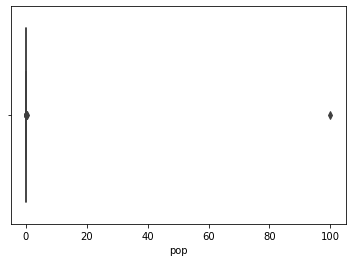

In [28]:
sns.boxplot(x=differences3['pop'])

In [31]:
# Find tract with 100% difference
tract_interpolated.loc[(tract_interpolated['pop'] - table_transferred['pop']) / tract_interpolated['pop'] * 100 > 1]



,GEOID,pop,housing,white,GEOID_10001040100,GEOID_10001040201,GEOID_10001040202,GEOID_10001040203,GEOID_10001040501,GEOID_10001040502,...,GEOID_10005051305,GEOID_10005051306,GEOID_10005051400,GEOID_10005051500,GEOID_10005051701,GEOID_10005051702,GEOID_10005051801,GEOID_10005051802,GEOID_10005051900,GEOID_10005990000
260,10005980000,0.961744,0.470161,0.461362,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# TODO: GEOID 10005980000 has a ground truth value of 0, a value of 0 using the conversion table, and values < 1 in the interpolation

# Remove outlier track from differences for now
table_transferred3 = table_transferred.loc[table_transferred["GEOID"] != 10005980000]
tract_interpolated3 = tract_interpolated.loc[tract_interpolated["GEOID"] != 10005980000]

In [33]:
# Calculate difference between ground truth data and interpolated data as a percentage of ground truth data
differences3 = (tract_interpolated3[['pop','housing','white']] - table_transferred3[['pop','housing','white']]) / tract_interpolated3[['pop','housing','white']] * 100

In [34]:
# Analyze percentile differences
differences3.apply(np.abs).describe()

,pop,housing,white
count,257.000000,257.000000,257.000000
mean,0.009656,0.021741,0.039884
std,0.031652,0.037972,0.138123
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.014148,0.034322,0.047849
max,0.476190,0.299259,1.915271


<AxesSubplot:xlabel='white'>

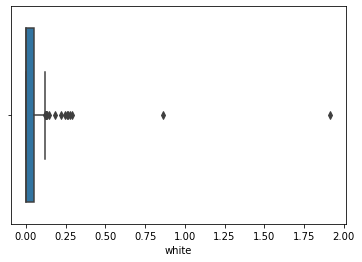

In [36]:
sns.boxplot(x=differences3['white'])